# Use to run models for pv detection


Modules

In [1]:
import pandas as pd
import numpy as np

from pandas import json_normalize
import json
from skimage.draw import polygon, polygon_perimeter
from skimage import measure
from skimage import io

from matplotlib.patches import Circle, Polygon
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns

import os
import dotenv

from roboflow import Roboflow 

import torch.nn as nn 
import torch
import pytorch_lightning as pl
from models.base import BaseModel 

import sys

from pycocotools.coco import COCO

Load the environment variables

In [2]:
dotenv.load_dotenv()

DATASET_KEY = os.getenv("API_KEY")

Load Data from Roboflow

In [3]:
# Load data from roboflow 
dotenv.load_dotenv()
DATASET_KEY = os.getenv('API_KEY')
if not os.path.exists(r'data/NL-Solar-Panel-Seg-1'):
    rf = Roboflow(api_key=DATASET_KEY)
    project = rf.workspace("electasolar").project("nl-solar-panel-seg")
    version = project.version(1)
    dataset = version.download("coco-segmentation")

Define Dataloaders

In [4]:
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from PIL import Image, ImageDraw
from torchvision import transforms
from torchvision.transforms import functional as TF

class CocoSegmentationDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.coco = COCO(annotation_dir)
        self.image_dir = image_dir
        self.image_ids = self.coco.getImgIds()
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        mask = self.create_mask(image_id, image_info)

        if self.transform is not None:
            image, mask = self.transform(image, mask)
        
        return image, mask
    
    def create_mask(self, image_id, image_info):
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = Image.new('L', (image_info['width'], image_info['height']))
        for ann in anns:
            if 'segmentation' in ann:
                ImageDraw.Draw(mask).polygon(ann['segmentation'][0], outline=1, fill=1)
        return mask

class JointTransform:
    def __call__(self, image, mask):
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask


def create_dataloader(image_dir, annotation_dir, batch_size, shuffle=True):
    dataset = CocoSegmentationDataset(image_dir, annotation_dir, transform=JointTransform())
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [5]:
def visualize_image_and_mask(image_batch, mask_batch, n_samples):

    image_batch = image_batch.cpu()
    mask_batch = mask_batch.cpu()

    for i in range(n_samples):
        img = image_batch[i].numpy().transpose(1,2,0)
        mask = mask_batch[i].numpy().squeeze()

        fig, axs = plt.subplots(1,2,figsize=(10,5))
        axs[0].imshow(img)
        axs[0].set_title(f'Image {i+1}')
        axs[0].axis('off')

        axs[1].imshow(img)
        axs[1].imshow(mask, alpha=0.5, cmap='jet')
        axs[1].set_title(f'Mask {i+1}')
        axs[1].axis('off')

        plt.tight_layout()
    plt.show()

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
torch.Size([10, 3, 640, 640])
torch.Size([10, 1, 640, 640])


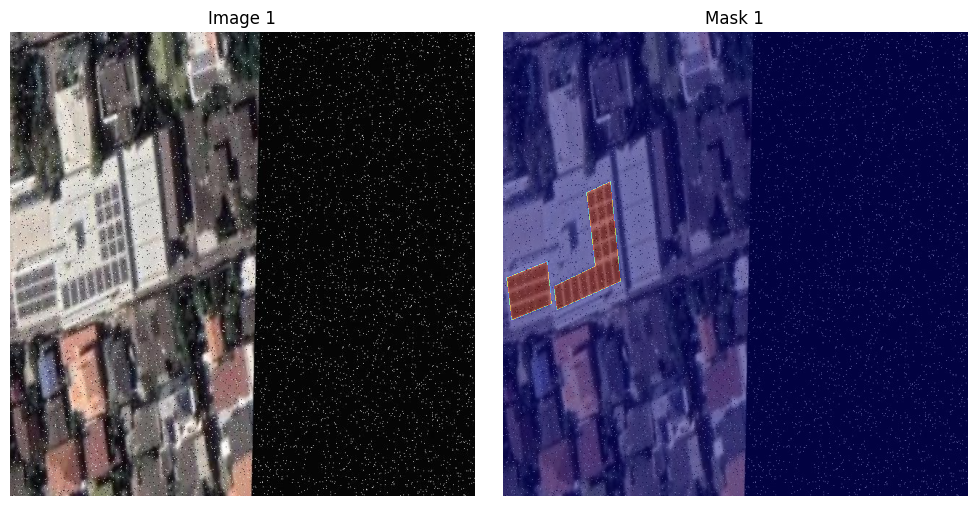

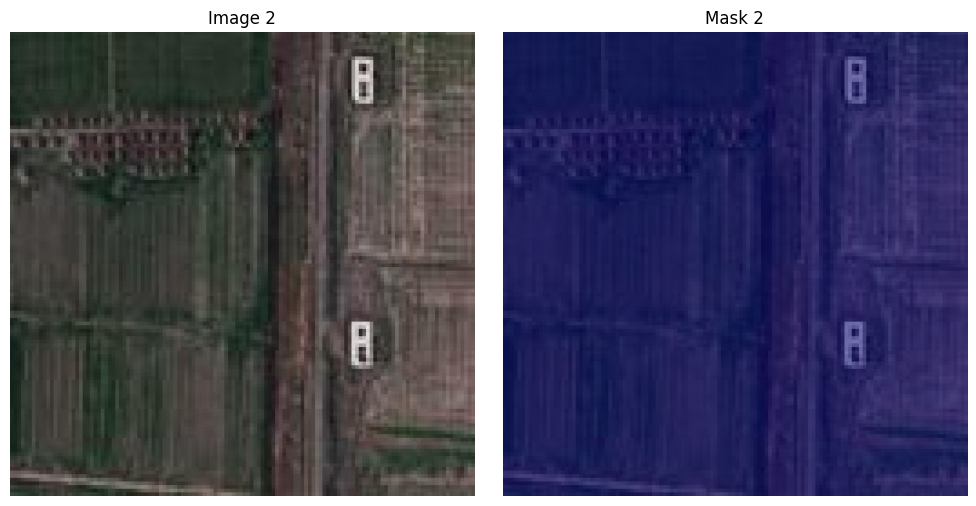

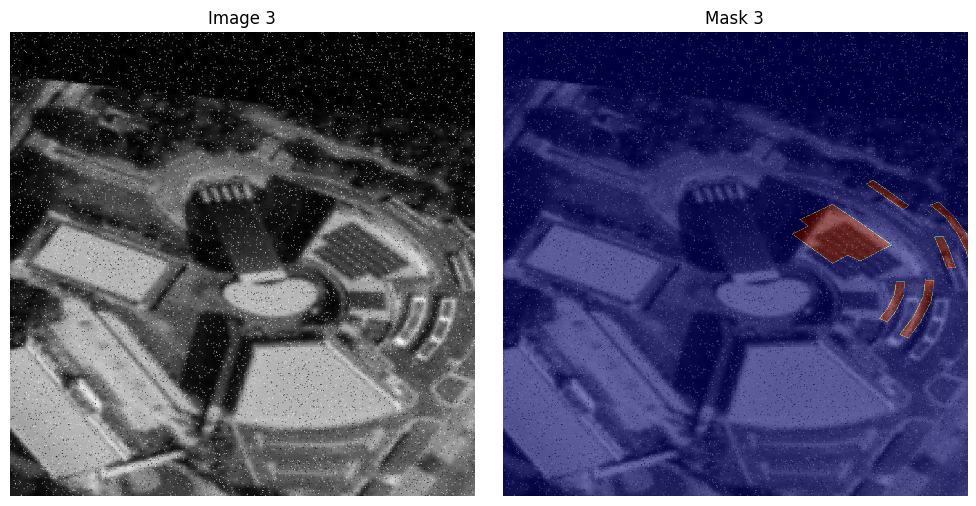

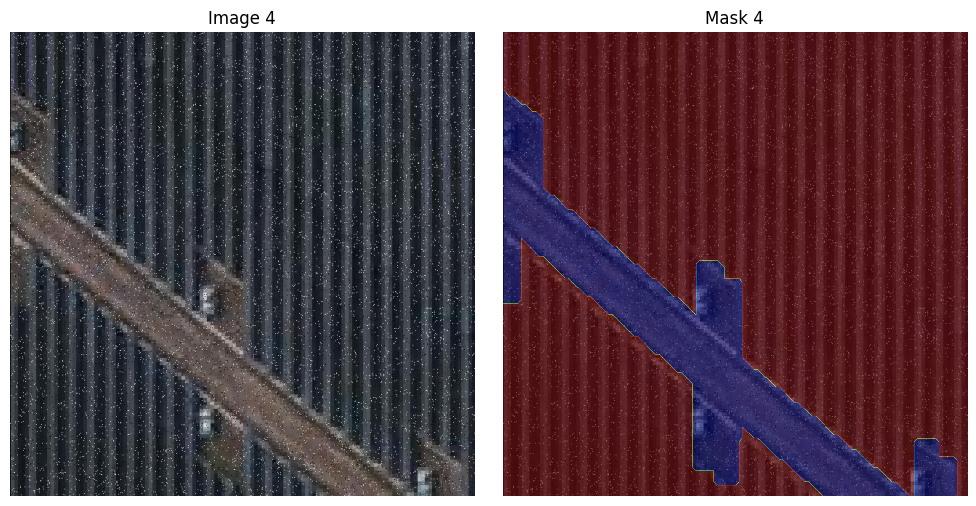

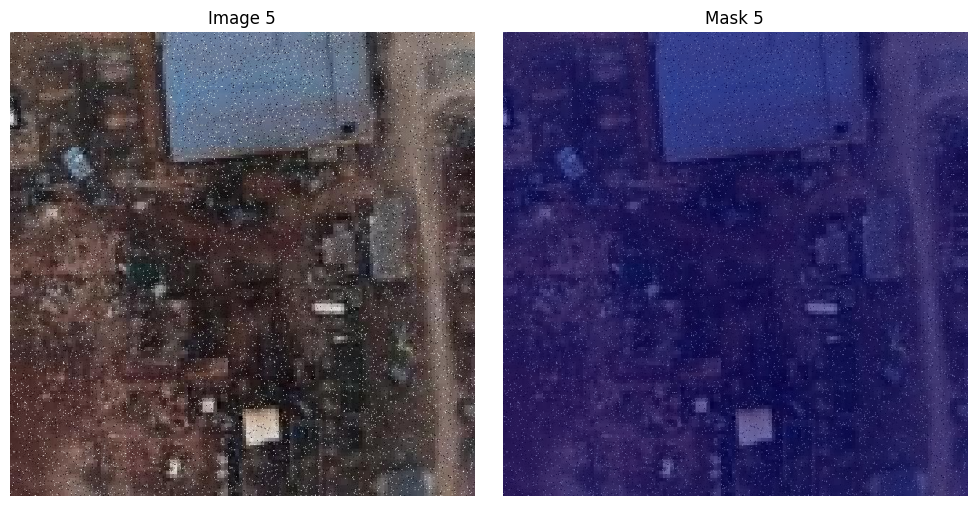

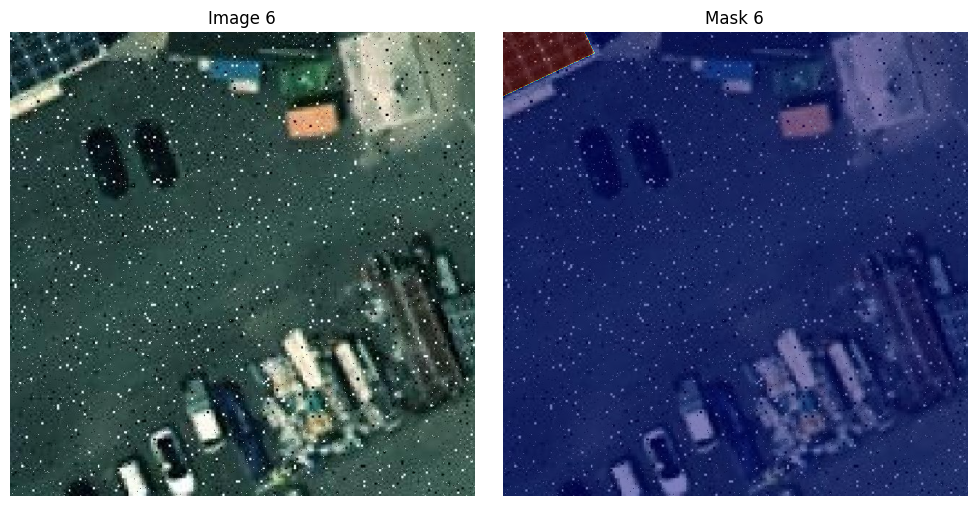

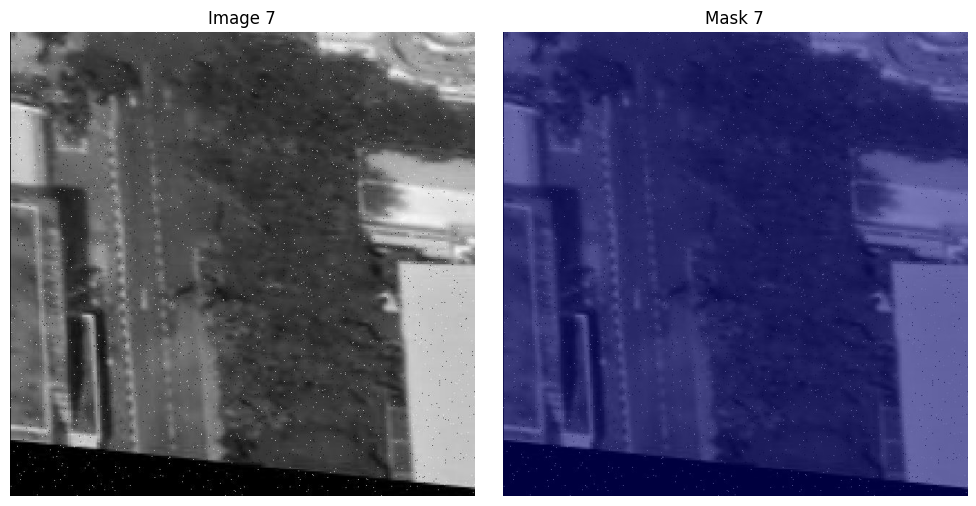

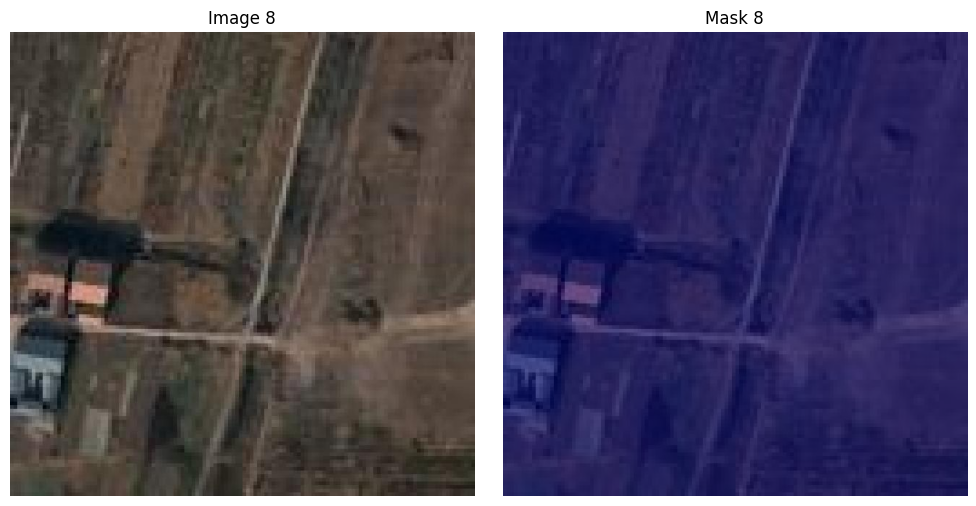

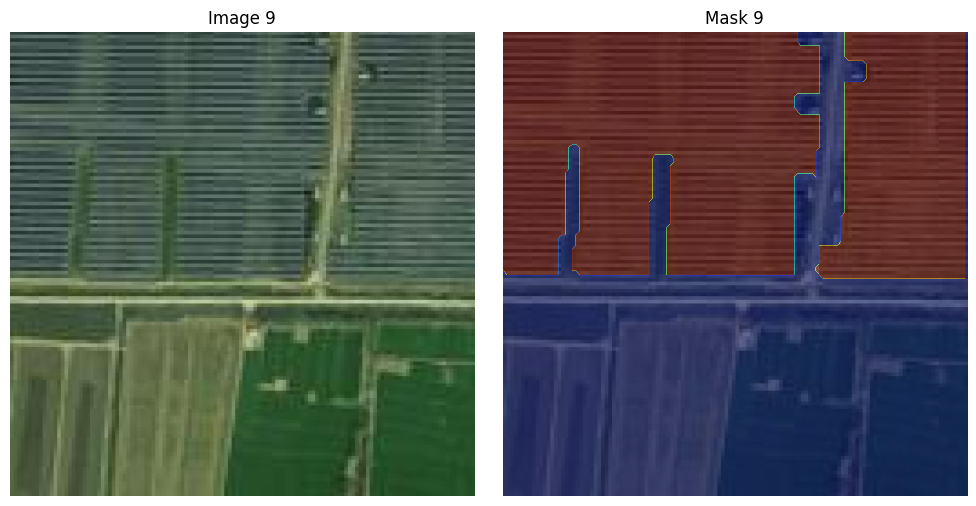

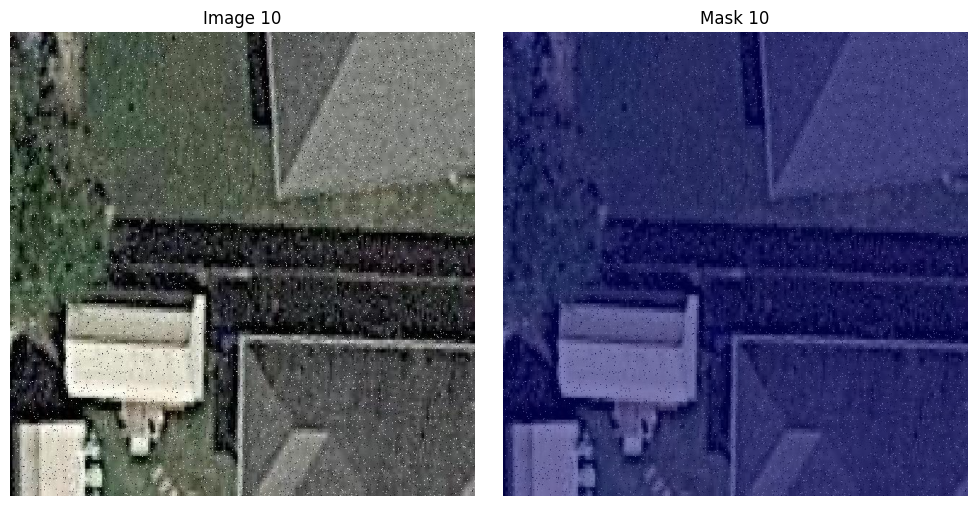

In [6]:
image_dir = "./data/NL-Solar-Panel-Seg-1/train"
ann_dir = "./data/NL-Solar-Panel-Seg-1/train/_annotations.coco.json"
batch_size = 10
dataloader = create_dataloader(image_dir, ann_dir, batch_size)

image, mask = next(iter(dataloader))

print(image.size())
print(mask.size())

visualize_image_and_mask(image, mask, 10)

Visualize Images


Load model 

In [8]:

from base_cnn import ImageRecognitionModel 
from image_recongnition import BaseModel

model = ImageRecognitionModel(hidden_size=32, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
metrics = {"accuracy": nn.CrossEntropyLoss()}
model = BaseModel(model, loss_fn, optimizer, scheduler, metrics)

trainer = pl.Trainer(max_epochs=10)

trainer.fit(model, train_loader, val_loader)

ModuleNotFoundError: No module named 'base_cnn'